# Total least squares (fit with errors bars in both x and y)

## Dealing with errors in $x$ and $y$
Taking both uncertainties in the independent variable $x$ and the dependent variable $y$ into accout is known as total least squares. Here we consider the case of a straight line fit. 

In [93]:
from sympy import *
from IPython.display import display, Latex
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit

For each data point we find the point $(x, y)$ for which the distance 
$$ d^2_i(x) = \left( \frac{m x + b - y_i}{\sigma_y} \right)^2 + \left( \frac{x - x_i}{\sigma_x} \right)^2$$ 
is mimimal.

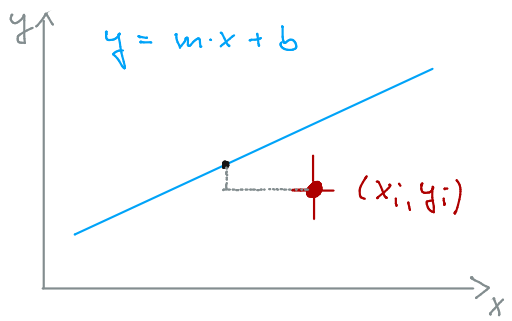

In [94]:
# find (x,y) on the line that minimizes the distance
# define distance d
x, m, b, x_i, y_i, sigma_x, sigma_y = symbols('x, m, b, x_i, y_i, sigma_x, sigma_y')
y = m*x + b
d2 = ((x - x_i) / sigma_x)**2 + ((y - y_i)/sigma_y)**2
d2

(b + m*x - y_i)**2/sigma_y**2 + (x - x_i)**2/sigma_x**2

In [95]:
# now find the minimum
d1 = diff(d,x)
x_min = solve(d1, x)
dmin = d.subs(x, x_min[0])
factor(simplify(dmin))

(b + m*x_i - y_i)**2/(m**2*sigma_x**2 + sigma_y**2)

So we see that compared to a fit without errors in $x$ one has the replacement:
$$\sigma_y^2 \to \sigma_y^2 + m^2 \sigma_x^2$$
This can be generalized to
$$\sigma_y^2 \to \sigma_y^2 + \left(\frac{df}{dx}\right)^2 \sigma_x^2 $$

## Comparison of iminuit and scipy.odr results

In [96]:
xd = np.array([1., 2., 3., 4., 5.])
yd = np.array([1.7, 2.3, 3.5, 3.3, 4.3])
# xd_err = np.array([0.0001, 0.0001, 0.0001, 0.0001, 0.0001])
xd_err = np.array([0.3, 0.3, 0.3, 0.3, 0.3])
yd_err = np.array([0.5, 0.3, 0.4, 0.4, 0.6])

### Modified variance formula with iminuit

In [97]:
def f(x, theta0, theta1):
    return theta0 + theta1*x

In [98]:
def dist2(theta0, theta1):
    fy = f(xd, theta0, theta1)
    d2 = (yd - fy)**2 / (theta1**2 * xd_err**2 + yd_err**2)
    return np.sum(d2)

In [99]:
m = Minuit(dist2, theta0=1, theta1=0.5, error_theta0=0.01, error_theta1=0.01, errordef=1)
m.migrad()

------------------------------------------------------------------
| FCN = 1.879                   |      Ncalls=35 (35 total)      |
| EDM = 1.49e-05 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
--------------------------------------------------------------------------------------------
|   | Name   |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------------------------------------------------------------------------------------
| 0 | theta0 |    1.1    |    0.5    |            |            |         |         |       |
| 1 | theta1 |   0.63    |   0.17    |            |            |         |         |       |
--------------------------------------------------------------------------------------------

In [100]:
print(f" theta0 = {m.values['theta0']} +/- {m.errors['theta0']}")
print(f" theta1 = {m.values['theta1']} +/- {m.errors['theta1']}")

 theta0 = 1.1257789594096785 +/- 0.5107574375153145
 theta1 = 0.628258447118388 +/- 0.16774326040609291


### scipy.odr

In [101]:
from scipy.odr import *
def f_odr(A, x):
    return A[1]*x + A[0]
linear = Model(f_odr)
mydata = RealData(xd, yd, sx=xd_err, sy=yd_err)
myodr = ODR(mydata, linear, beta0=[1., 1.])
myoutput = myodr.run()
myoutput.pprint()

Beta: [1.12453015 0.62883524]
Beta Std Error: [0.40190507 0.13164797]
Beta Covariance: [[ 0.25786315 -0.07740785]
 [-0.07740785  0.02766755]]
Residual Variance: 0.6264085831986289
Inverse Condition #: 0.10986215845704737
Reason(s) for Halting:
  Sum of squares convergence


## Comparison of our result and the scipy.odr results in the same plot

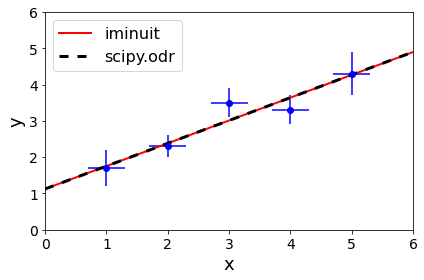

In [103]:
xf = np.linspace(0., 6., 1000)

# iminuit
theta0 = m.values["theta0"]
theta1 = m.values["theta1"]
yf = f(xf, theta0, theta1)

# scipy.odr
theta0_odr = myoutput.beta[0]
theta1_odr = myoutput.beta[1]
yf_odr = f(xf, theta0_odr, theta1_odr)

plt.xlabel("x", fontsize=18)
plt.ylabel("y", fontsize=18)
plt.errorbar(xd, yd, yerr=yd_err, xerr=xd_err, fmt="bo")
plt.xlim(0., 6.)
plt.ylim(0., 6.)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(xf, yf, color="red", lw=2, label='iminuit')
plt.plot(xf, yf_odr, color="black", linestyle='--', dashes=(3, 3), lw=3, label='scipy.odr')
plt.legend(loc='upper left', fontsize=16)
plt.tight_layout()

## Comparison with root

The root function `TGraphErrors::Fit` by default takes error in $x$ and $y$ into account. The root fit results and uncertainties agree with the results we obtain here with iminuit and the modified expression for the variance:

    void total_least_squares() {
	
	double xd[5] = {1., 2., 3., 4., 5.};
	double yd[5] = {1.7, 2.3, 3.5, 3.3, 4.3};
	double xd_err[5] = {0.3, 0.3, 0.3, 0.3, 0.3};
	double yd_err[5] = {0.5, 0.3, 0.4, 0.4, 0.6};

	TGraphErrors* gey = new TGraphErrors(5, xd, yd, 0, yd_err);
	TGraphErrors* gexy = new TGraphErrors(5, xd, yd, xd_err, yd_err);

	TCanvas* c1 = new TCanvas("c1");
	TH2F* frame = new TH2F("frame", ";x;y", 1, 0., 6., 1, 0., 5.5);
	frame->Draw();
	gexy->SetMarkerStyle(kFullCircle);
	gexy->SetMarkerColor(kBlue);
	gexy->Draw("p");

	TF1* f = new TF1("f", "pol1", 0., 10.);

	gexy->Fit("f", "F");
	// gey->Fit("f", "F");

}



    root [0] 
    Processing total_least_squares.C...
     FCN=1.87923 FROM MIGRAD    STATUS=CONVERGED      56 CALLS          57 TOTAL
                     EDM=1.04645e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
      EXT PARAMETER                                   STEP         FIRST   
      NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
       1  p0           1.12450e+00   5.10922e-01   1.68346e-04  -3.89787e-04
       2  p1           6.28844e-01   1.67808e-01   5.52908e-05  -3.67463e-04


## References
* [Total least squares](https://en.wikipedia.org/wiki/Total_least_squares)
* [root TGraphErrors::Fit](https://root.cern.ch/doc/master/classTGraph.html#a61269bcd47a57296f0f1d57ceff8feeb)